In [46]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import os
import csv
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
transform=transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
])

In [120]:
class SampleDataset(Dataset):
    def __init__(self, image_dir, conductivities, transform=None):
        self.conds=conductivities
        self.samples=[]
        for filename in sorted(os.listdir(image_dir), key=lambda x: int(x[:-5])):
            self.samples.append(transform(Image.open(image_dir+filename)))
        self.samples=torch.stack(tensors=self.samples)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        return self.samples[index], self.conds[index]
    
    def to(self, device):
        self.samples=self.samples.to(device)
        self.conds=self.conds.to(device)

In [132]:
with open('./data/data.csv') as f:
    reader=csv.reader(f)
    d=list(reader)
conductivities=torch.tensor(data=[float(x[2]) for x in d[1:]], dtype=torch.float32)
volPer=torch.tensor(data=[float(x[1]) for x in d[1:]], dtype=torch.float32)
conductivities
dataset=SampleDataset('./data/samples/', conductivities, transform)
dataset.to('cuda')

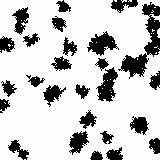

In [133]:
tensorToImageTransform=tv.transforms.ToPILImage()
tensorToImageTransform(dataset[4][0])

In [134]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_filters, image_size):
        super(CNN, self).__init__()

        #calculating image resolution as we progress through model
        image_size_1=(image_size-8+1)//2
        image_size_2=(image_size_1-4+1)//2
        self.conv=torch.nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=num_filters, kernel_size=(8, 8), stride=1),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.BatchNorm2d(num_features=num_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=num_filters, out_channels=num_filters*2, kernel_size=(4, 4), stride=1),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.BatchNorm2d(num_features=num_filters*2),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(in_features=image_size_2*image_size_2*num_filters*2, out_features=150),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=150, out_features=84),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=84, out_features=1)
        )

    def forward(self, x):
        return self.conv(x)

In [135]:
model=CNN(1, 32, 160).to('cuda')
# model(dataset[:][0]).view(1024).shape

In [136]:
train_dataset, test_dataset=torch.utils.data.random_split(dataset=dataset, lengths=[0.8, 0.2])
len(train_dataset), len(test_dataset)
test_dataset[:][1]

tensor([1.2736, 1.1658, 1.1343, 1.2087, 1.4737, 1.0243, 1.5006, 1.4896, 1.0960,
        1.3487, 1.4704, 1.4566, 1.4954, 1.4273, 1.3509, 1.4476, 1.3712, 1.2123,
        1.4420, 1.1188, 1.3994, 1.3430, 1.3508, 1.4520, 1.2677, 1.3473, 1.3260,
        1.1708, 1.4947, 1.4496, 1.4911, 1.4959, 1.3439, 1.4977, 1.4570, 1.1420,
        1.4032, 1.2697, 1.5004, 1.4824, 1.3073, 1.4563, 1.1038, 1.4573, 1.4821,
        1.2365, 1.1222, 1.4852, 1.4878, 1.4187, 1.0634, 1.3078, 1.4286, 1.0042,
        1.4207, 1.2295, 1.4965, 1.3437, 1.1189, 1.4200, 1.3488, 1.3196, 1.4685,
        1.2088, 1.3346, 1.5045, 1.2682, 1.3756, 1.0743, 1.3251, 1.4801, 1.4699,
        1.4346, 1.2669, 1.2205, 1.0957, 1.3029, 1.0848, 1.3532, 1.4197, 1.2916,
        1.0873, 1.2898, 1.3742, 1.4983, 1.4925, 1.1169, 1.4149, 1.3373, 1.4610,
        1.1467, 1.4442, 1.4821, 1.4651, 1.5036, 1.4833, 1.2474, 1.4700, 1.2086,
        1.4551, 1.3634, 1.3865, 1.0587, 1.0881, 1.4222, 1.4902, 1.0278, 1.1678,
        1.4117, 1.5077, 1.4685, 1.4749, 

In [137]:
def train_CNN(train_data, model, loss_fn, optimizer, epochs):
    for epoch in range(epochs):
        dataloader=DataLoader(train_data, batch_size=32, shuffle=True)
        running_loss=0
        best_loss=2**63
        for batch in dataloader:
            inputs, labels=batch
            optimizer.zero_grad()
            pred=model(inputs)
            loss=loss_fn(pred, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        print(epoch, running_loss/len(dataloader))
        if best_loss>running_loss/len(dataloader):
            best_loss=running_loss/len(dataloader)
            torch.save(model.state_dict(), "CNN_BEST.pt")
        if epoch%1000==0:
            torch.save(model.state_dict(), "CNN"+str(epoch)+".pt")

In [138]:
train_CNN(train_dataset, model, torch.nn.MSELoss(), torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5), 1000)

0 51.67145264806011
1 0.09246183734817001
2 0.01818742841267242
3 0.01447522110090806
4 0.020560886764612336
5 0.014097985121994637
6 0.01591668379618428
7 0.008387058359893182
8 0.007970065899336567
9 0.012024730005158255
10 0.013655590359121561
11 0.00485726834113638
12 0.019214356922580358
13 0.010356782528106123
14 0.07316522603818718
15 0.051121402030380875
16 0.01180132392507333
17 0.008520881537921153
18 0.010067246008055428
19 0.014784366349116541
20 0.03126222107451982
21 0.037112983145142116
22 0.006800532672339334
23 0.017906408425635442
24 0.01523039649383953
25 0.010441044323110523
26 0.012323825409671722
27 0.011465153795702813
28 0.004304467109390176
29 0.0077572522680454245
30 0.004495934970551529
31 0.00914024734027827
32 0.008156227498637656
33 0.00851628447820146
34 0.01903719232023622
35 0.009275740184910739
36 0.005920136078762321
37 0.018723210118388615
38 0.013642796404803028
39 0.012373376489939312
40 0.015725186394635014
41 0.010102707829971153
42 0.01082618590

In [139]:
with torch.no_grad():
    pred=model(test_dataset[:][0])
    actual=test_dataset[:][1].unsqueeze(1)
for i in range(len(test_dataset)):
    print(pred[i].item(), actual[i].item(), pred[i].item()-actual[i].item())
print(nn.MSELoss()(pred, actual).item())

1.2660236358642578 1.273626685142517 -0.007603049278259277
1.1826772689819336 1.1657675504684448 0.01690971851348877
1.1376888751983643 1.1342544555664062 0.003434419631958008
1.1983962059020996 1.2086966037750244 -0.010300397872924805
1.4537523984909058 1.4736520051956177 -0.019899606704711914
1.0743465423583984 1.0243399143218994 0.05000662803649902
1.4976246356964111 1.5005669593811035 -0.002942323684692383
1.5070960521697998 1.4896386861801147 0.01745736598968506
1.1052123308181763 1.0959925651550293 0.009219765663146973
1.3536616563796997 1.3487087488174438 0.004952907562255859
1.4206056594848633 1.4704277515411377 -0.049822092056274414
1.454741358757019 1.4565620422363281 -0.001820683479309082
1.4804067611694336 1.4954171180725098 -0.015010356903076172
1.4187510013580322 1.4273039102554321 -0.008552908897399902
1.3272762298583984 1.3509340286254883 -0.023657798767089844
1.461194634437561 1.4476457834243774 0.013548851013183594
1.3595879077911377 1.3711886405944824 -0.011600732803

In [140]:
load_model=CNN(1, 32, 160)
load_model.load_state_dict(torch.load('CNN_BEST.pt'))
load_model.eval()
load_model=load_model.to('cuda')

C:\Users\User\AppData\Local\Temp\ipykernel_10916\1805226665.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model.load_state_dict(torch.load('CNN_BEST.pt'))


In [141]:
pred=load_model(test_dataset[:][0])
actual=test_dataset[:][1].unsqueeze(1)

In [142]:
for i in range(len(actual)):
    print(actual[i].item(), pred[i].item(), abs(actual[i].item()-pred[i].item()))
print(nn.MSELoss()(pred, actual).item())

1.273626685142517 1.2364215850830078 0.03720510005950928
1.1657675504684448 1.154045820236206 0.01172173023223877
1.1342544555664062 1.1072832345962524 0.02697122097015381
1.2086966037750244 1.1686954498291016 0.04000115394592285
1.4736520051956177 1.4317048788070679 0.041947126388549805
1.0243399143218994 1.044306755065918 0.019966840744018555
1.5005669593811035 1.4806419610977173 0.01992499828338623
1.4896386861801147 1.4911783933639526 0.0015397071838378906
1.0959925651550293 1.0792005062103271 0.01679205894470215
1.3487087488174438 1.3235032558441162 0.025205492973327637
1.4704277515411377 1.4076250791549683 0.06280267238616943
1.4565620422363281 1.4336045980453491 0.022957444190979004
1.4954171180725098 1.4610176086425781 0.03439950942993164
1.4273039102554321 1.3983619213104248 0.028941988945007324
1.3509340286254883 1.3027838468551636 0.04815018177032471
1.4476457834243774 1.4416477680206299 0.005998015403747559
1.3711886405944824 1.3312443494796753 0.03994429111480713
1.2123136

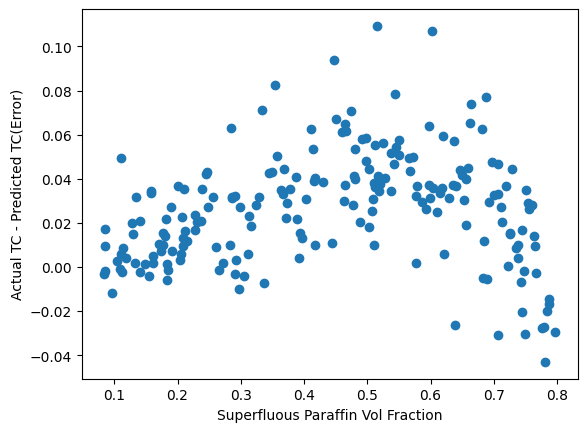

In [143]:
with torch.no_grad():
    actual=actual.to('cpu')
    pred=pred.to('cpu')
    superfluousVolPers=[torch.sum(x[0]).item()/(160*160) for x in test_dataset]
    plt.scatter(superfluousVolPers, (actual-pred))
    plt.xlabel('Superfluous Paraffin Vol Fraction')
    plt.ylabel('Actual TC - Predicted TC(Error)')

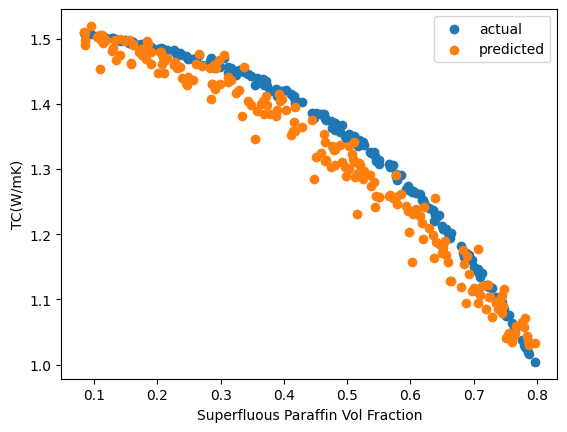

In [144]:
with torch.no_grad():
    plt.scatter(superfluousVolPers, actual, label='actual')
    plt.scatter(superfluousVolPers, pred, label='predicted')
    plt.xlabel('Superfluous Paraffin Vol Fraction')
    plt.ylabel('TC(W/mK)')
    plt.legend()

[0.7961659240722656, 0.7967507934570313, 0.7956734466552734, 0.7947026062011718, 0.7941431427001953, 0.7927256011962891, 0.7925934600830078, 0.7913878631591796, 0.7918032073974609, 0.7907488250732422, 0.7896830749511718, 0.7880194854736328, 0.7876584625244141, 0.7874153137207032, 0.7866779327392578, 0.7855860900878906, 0.7844264221191406, 0.7844598388671875, 0.7831632232666016, 0.7826658630371094, 0.7825096893310547, 0.780872573852539, 0.7804904174804688, 0.7795454406738281, 0.7785743713378906, 0.7783094787597656, 0.7780731964111328, 0.775887451171875, 0.7751361846923828, 0.7753070831298828, 0.7736173248291016, 0.7730316162109375, 0.7732080078125, 0.7713025665283203, 0.771162109375, 0.7698149108886718, 0.769359359741211, 0.768846664428711, 0.7683882141113281, 0.7677420806884766, 0.7670374298095703, 0.7662237548828125, 0.7652980804443359, 0.7649835968017578, 0.7637179565429687, 0.7634976959228515, 0.7629361724853516, 0.7616851806640625, 0.7608056640625, 0.7606340026855469, 0.75890708923

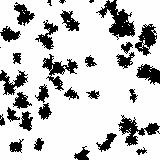

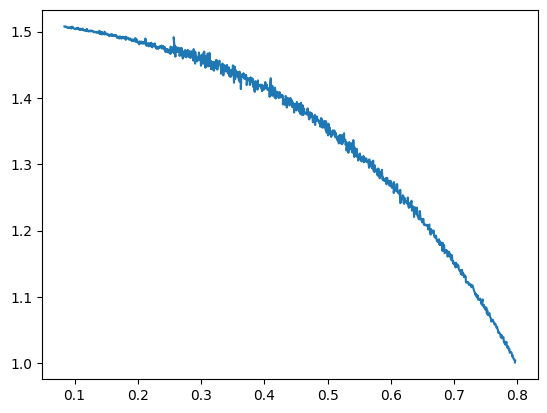

In [148]:
with torch.no_grad():
    dataset.to('cpu')
    spVolPers=[torch.sum(x[0]).item()/(160*160) for x in dataset]
    print(spVolPers)
    display(tensorToImageTransform(dataset[5][0]))
    plt.plot(spVolPers, dataset[:][1])

In [151]:
for i in range(len(conductivities)):
    print(i, spVolPers[i]-volPer[i].item())
print(spVolPers-volPer)
plt.scatter(spVolPers, volPer)

0 -0.0028184247016906916
1 -0.0014914178848266513
2 -0.0017484259605408115
3 -0.00197706937789921
4 -0.0017943358421326217
5 -0.002430639266967738
6 -0.0018205833435058771
7 -0.0022449421882629883
8 -0.0010483598709106756
9 -0.0013605451583862394
10 -0.0016450572013855247
11 -0.0025274085998535645
12 -0.0021462345123290927
13 -0.0016081452369689497
14 -0.0016033291816711648
15 -0.0019139337539673118
16 -0.0022923040390014915
17 -0.0015167498588561923
18 -0.0020320677757262873
19 -0.0017872905731201039
20 -0.00116216659545898
21 -0.002057085037231454
22 -0.0016580033302306951
23 -0.0018217420578002796
24 -0.0020506143569946067
25 -0.0015342688560485707
26 -0.001028354167938228
27 -0.0024328613281250355
28 -0.002441930770874068
29 -0.0014897942543029563
30 -0.0023983144760131303
31 -0.00224182605743406
32 -0.0013232374191284313
33 -0.002447440624237074
34 -0.001806659698486368
35 -0.0024116611480713424
36 -0.0020859742164611728
37 -0.0018564724922179865
38 -0.0015336847305298384
39 -0.00

TypeError: unsupported operand type(s) for -: 'list' and 'Tensor'

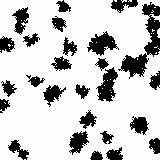

In [147]:
tensorToImageTransform(dataset[4][0])
# torch.sum(dataset[4][0])/(160*160), volPer[4], spVolPers[4]